# Help Diagnosing Heart Diseases 

- MRI videos with 30-frame in Dicom format
- Very interesting and meaningful problem: predict cardiac volumes using data science
- total 700 patients' data to train and validate
- Kaggle 2015 data science bowl
- Top 3 winners all use convolutional neural networks, but I didn't see any reports on using ResNet architecture. 

In [243]:
HTML('<img src="./images/213_ch2.gif">')

In [2]:
import dicom
import os
import numpy as np
from matplotlib import pyplot

from scipy.misc import imresize
from scipy.stats import norm
%matplotlib inline
from IPython.display import HTML, Image

from sklearn.model_selection import train_test_split

from skimage.restoration import denoise_tv_chambolle
from scipy import ndimage

from keras.models import Sequential
from keras.layers import Input, Conv2D, Activation, Dense, Flatten, Add, ZeroPadding2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.optimizers import Adam
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.initializers import he_uniform
from keras.callbacks import History
K.set_image_data_format('channels_first')

Using TensorFlow backend.


## Plot one example of MRI heart image

In [57]:
PathDicom = "./data/train/1/study/2ch_21"
lstFilesDCM = []  
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))
# Get ref file
RefDs = dicom.read_file(lstFilesDCM[1])
# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (len(lstFilesDCM),int(RefDs.Rows), int(RefDs.Columns))
print('Pixel dimension',ConstPixelDims)
# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))
x_grid = numpy.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y_grid = numpy.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z_grid = numpy.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])
ArrayDicom = numpy.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
for filenameDCM in lstFilesDCM:
    ds = dicom.read_file(filenameDCM)
    ArrayDicom[lstFilesDCM.index(filenameDCM),:, :] = ds.pixel_array 

Pixel dimension (30, 256, 256)


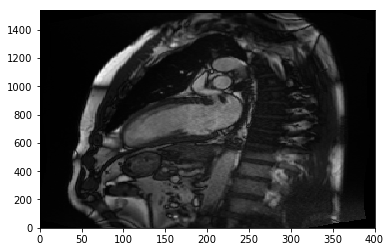

In [177]:
pyplot.pcolormesh(y_grid, z_grid, numpy.flipud(ArrayDicom[0,:, :]))

## Load all heart images (.dicom files), resize to (64, 64) and save to numpy array binary files

- resizing is just to save computer time
- original dicom files are huge ~ 40GB, array binary files ~600 MB

In [12]:
img_resize = True
img_shape = (64, 64)

def crop_resize(img):
    """
    Crop center and resize.

    :param img: image to be cropped and resized.
    """
    if img.shape[0] < img.shape[1]:
        img = img.T
    # we crop image from center
    short_edge = min(img.shape[:2])
    yy = int((img.shape[0] - short_edge) / 2)
    xx = int((img.shape[1] - short_edge) / 2)
    crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
    img = crop_img
    img = imresize(img, img_shape)
    return img

def load_images(from_dir, verbose=True):
    """ 
    Load images in the form study x slices x width x height.
    Each image contains 30 time series frames so that it is ready for the convolutional network.

    :param from_dir: directory with images (train or validate)
    :param verbose: if true then print data
    """
    print('-'*50)
    print('Loading all DICOM images from {0}...'.format(from_dir))
    print('-'*50)

    current_study_sub = ''  # saves the current study sub_folder
    current_study = ''  # saves the current study folder
    current_study_images = []  # holds current study images
    ids = []  # keeps the ids of the studies
    study_to_images = dict()  # dictionary for studies to images
    total = 0 
    images = []  # saves 30-frame-images
    from_dir = from_dir if from_dir.endswith('/') else from_dir + '/' 
    for subdir, _, files in os.walk(from_dir):
        subdir = subdir.replace('\\', '/')  # windows path fix
        subdir_split = subdir.split('/')
        study_id = subdir_split[-3]
        if "sax" in subdir:
            for f in files:
                image_path = os.path.join(subdir, f)
                if not image_path.endswith('.dcm'):
                    continue

                image = dicom.read_file(image_path)
                image = image.pixel_array.astype(float)
                image /= np.max(image)  # scale to [0,1]
                if img_resize:
                    image = crop_resize(image)

                if current_study_sub != subdir:
                    x = 0 
                    try:
                        while len(images) < 30: 
                            images.append(images[x])
                            x += 1
                        if len(images) > 30: 
                            images = images[0:30]
                    except IndexError:
                        pass
                    current_study_sub = subdir
                    current_study_images.append(images)
                    images = []

                if current_study != study_id:
                    study_to_images[current_study] = np.array(current_study_images)
                    if current_study != "":
                        ids.append(current_study)
                    current_study = study_id
                    current_study_images = []
                images.append(image)
                if verbose:
                    if total % 1000 == 0:
                        print('Images processed {0}'.format(total))
                total += 1
    x = 0
    try:
        while len(images) < 30:
            images.append(images[x])
            x += 1
        if len(images) > 30:
            images = images[0:30]
    except IndexError:
        pass

    print('-'*50)
    print('All DICOM in {0} images loaded.'.format(from_dir))
    print('-'*50)

    current_study_images.append(images)
    study_to_images[current_study] = np.array(current_study_images)
    if current_study != "":
        ids.append(current_study)

    return ids, study_to_images

study_ids, images = load_images('data/train_small')  # load images and their ids

--------------------------------------------------
Loading all DICOM images from data/train_small...
--------------------------------------------------
Images processed 0
Images processed 1000
Images processed 2000
Images processed 3000
--------------------------------------------------
All DICOM in data/train_small/ images loaded.
--------------------------------------------------


In [13]:
def map_studies_results():
    """ 
    Maps studies to their respective targets.
    """
    id_to_results = dict()
    train_csv = open('data/train.csv')
    lines = train_csv.readlines()
    i = 0 
    for item in lines:
        if i == 0:
            i = 1 
            continue
        id, diastole, systole = item.replace('\n', '').split(',')
        id_to_results[id] = [float(diastole), float(systole)]

    return id_to_results

studies_to_results = map_studies_results()

In [15]:
def write_npy(file_path, X_name, y_name):
    """ 
    Loads the training data set including X and y and saves it to .npy file.
    """
    print('-'*50)
    print('Writing training data to .npy file...')
    print('-'*50)

    study_ids, images = load_images(file_path)  # load images and their ids
    studies_to_results = map_studies_results()  # load the dictionary of studies to targets
    X = []
    y = []

    for study_id in study_ids:
        study = images[study_id]
        outputs = studies_to_results[study_id]
        for i in range(study.shape[0]):
            X.append(study[i, :, :, :]) 
            y.append(outputs)

    X = np.array(X, dtype=np.uint8)
    y = np.array(y)
    np.save('data/'+ X_name + '.npy', X)
    np.save('data/'+ y_name+'.npy', y)
    print('Done.')
    
write_npy('./data/train_small', 'X_train_small','y_train_small')
#write_npy('./data/validate', 'X_validate_small','y_validate_small')

--------------------------------------------------
Writing training data to .npy file...
--------------------------------------------------
--------------------------------------------------
Loading all DICOM images from ./data/train_small...
--------------------------------------------------
Images processed 0
Images processed 1000
Images processed 2000
Images processed 3000
--------------------------------------------------
All DICOM in ./data/train_small/ images loaded.
--------------------------------------------------
Done.


## Convolutional neural networks architectures: ResNet 50

- Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun - Deep Residual Learning for Image Recognition (2015)
- 50 layers

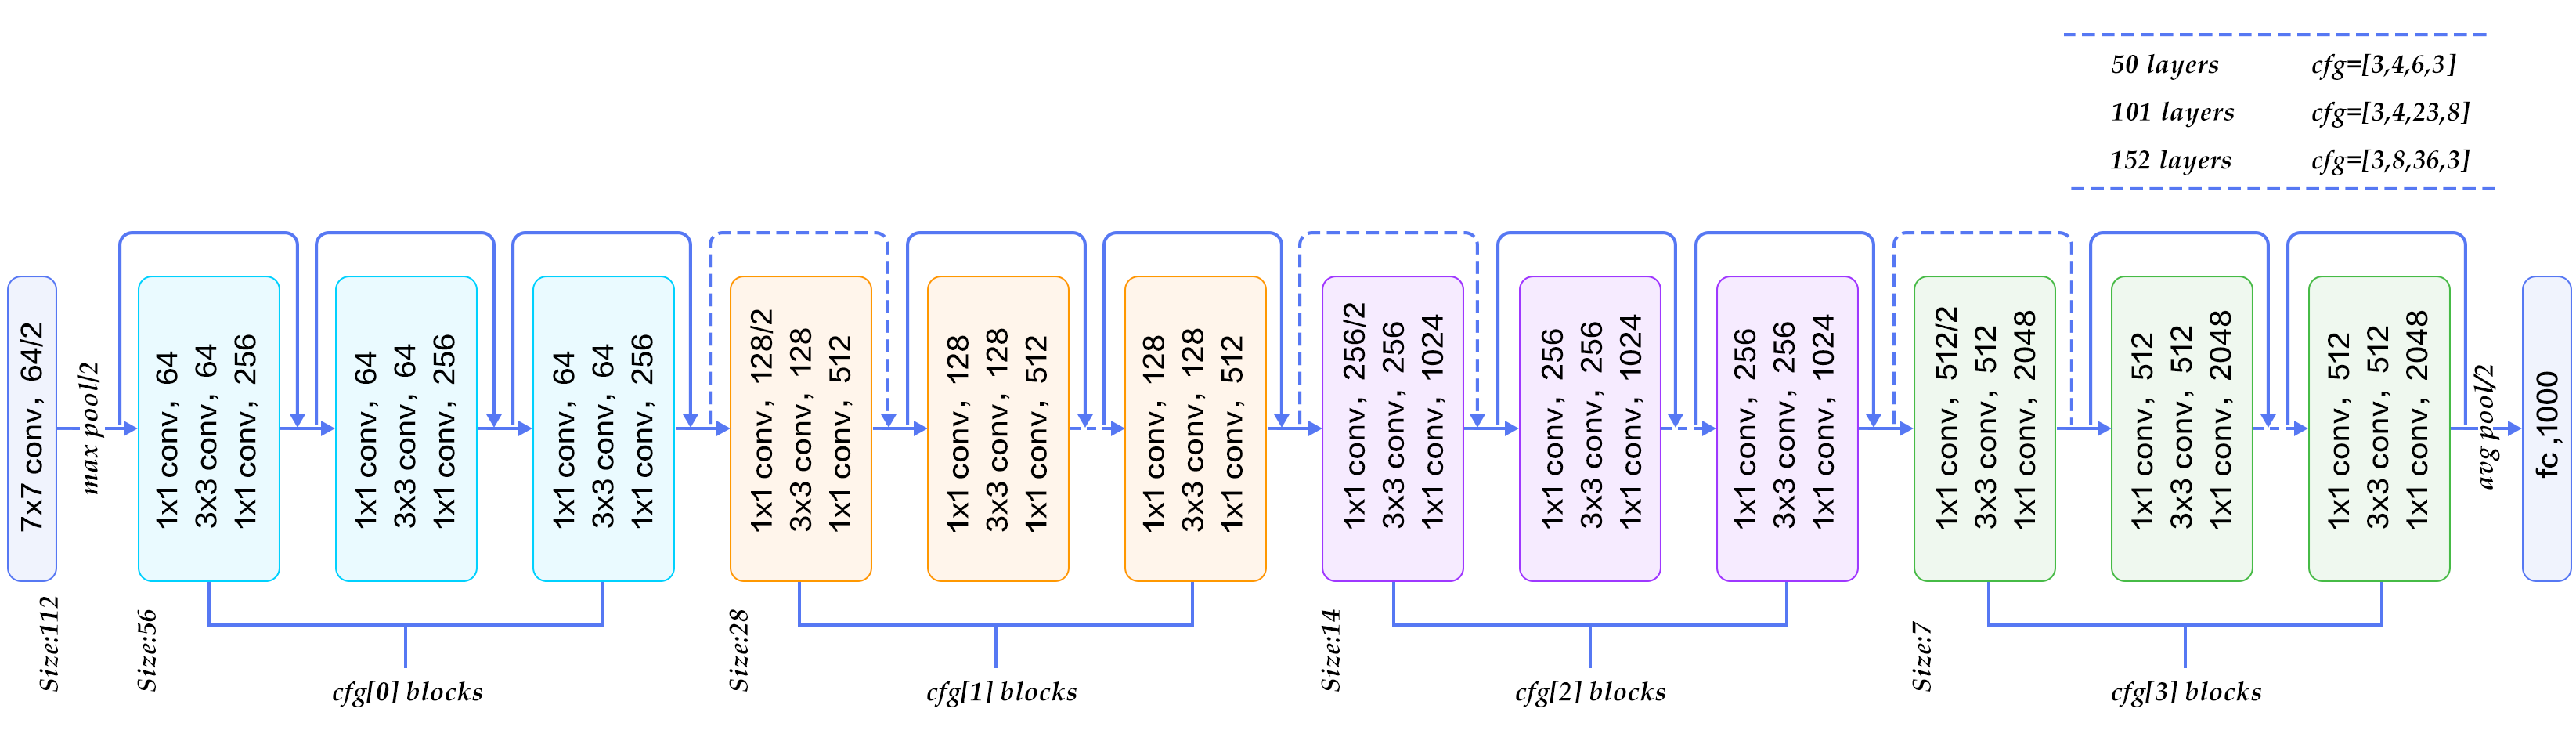

In [242]:
Image(filename='images/resnet.png') 

In [47]:
def root_mean_squared_error(y_true, y_pred):
    """ 
    RMSE loss function
    """
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def identity_block(X, filters, f, s=1):
    F1, F2, F3 = filters
    X_shortcut = X 
    X = Conv2D(F1, (1,1),padding = 'valid', kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis = 1)(X)
    X = Activation('relu')(X)

    X = Conv2D(F2, (f,f),padding = 'same', kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis = 1)(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1,1),padding = 'valid', kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis = 1)(X)

    X = Add()([X_shortcut, X]) 
    X = Activation('relu')(X)
    return X


def conv_block(X, filters, f, s = 2): 
    F1, F2, F3 = filters
    X_shortcut = X 

    X = Conv2D(F1, (1,1),strides=(s,s),padding = 'valid', kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis = 1)(X)
    X = Activation('relu')(X)

    X = Conv2D(F2, (f,f),padding = 'same', kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis = 1)(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1,1),padding = 'valid', kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis = 1)(X)

    X_shortcut = Conv2D(F3, (1,1),strides=(s,s), padding = 'valid', kernel_initializer='glorot_uniform')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 1)(X_shortcut)

    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    return X

def big_block(X, num_repeat, filters, f_conv, s_conv, f_id, s_id):
    X = conv_block(X, filters,f=f_conv, s=s_conv)
    for _ in range(num_repeat-1):
        X = identity_block(X, filters,f=f_id, s=s_id)
    return X


In [48]:
def get_model():
    X_input = Input(shape=(30,64,64))
    #stage 1
    X = ZeroPadding2D((3,3))(X_input)
    X = Conv2D(64, (7, 7), strides=(2,2),kernel_initializer='glorot_uniform')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3), strides=(2,2))(X)
    #stage 2
    X = big_block(X, num_repeat=3, filters=[64,64,256], f_conv=3, s_conv=1, f_id=3, s_id=1)
    #stage 3
    X = big_block(X, num_repeat=4, filters=[128,128,512], f_conv=3, s_conv=2, f_id=3, s_id=1)
    #stage 4
    X = big_block(X, num_repeat=6, filters=[256,256,1024], f_conv=3, s_conv=2, f_id=3, s_id=1)
    #stage 5
    X = big_block(X, num_repeat=3, filters=[512,512,2048], f_conv=3, s_conv=2, f_id=3, s_id=1)
    
    X = AveragePooling2D((2,2))(X)
    X = Flatten()(X)
    X = Dense(1)(X)

    adam = Adam(lr=0.0005)
    model = Model(inputs = X_input , outputs = X)
    model.compile(optimizer=adam, loss=root_mean_squared_error)
    return model

## Image augmentation

In [29]:
def rotation_augmentation(X, angle_range):
    #progbar = Progbar(X.shape[0])  # progress bar for augmentation status tracking

    X_rot = np.copy(X)
    for i in range(len(X)):
        angle = np.random.randint(-angle_range, angle_range)
        for j in range(X.shape[1]):
            X_rot[i, j] = ndimage.rotate(X[i, j], angle, reshape=False, order=1)
    #    progbar.add(1)
    return X_rot

def shift_augmentation(X, h_range, w_range):
    X_shift = np.copy(X)
    size = X.shape[2:]
    for i in range(len(X)):
        h_random = np.random.rand() * h_range * 2. - h_range
        w_random = np.random.rand() * w_range * 2. - w_range
        h_shift = int(h_random * size[0])
        w_shift = int(w_random * size[1])
        for j in range(X.shape[1]):
            X_shift[i, j] = ndimage.shift(X[i, j], (h_shift, w_shift), order=0)
    return X_shift

## Train data set

In [19]:
def load_data():
    X = np.load('data/X_train_small.npy')
    y = np.load('data/y_train_small.npy')
    #X = preprocess(X)
    X = X/255
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print('X_train shape', X_train.shape,'X_test shape', X_test.shape)
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = load_data()


X_train shape (90, 30, 64, 64) X_test shape (23, 30, 64, 64)


In [25]:
def real_to_cdf(y, sigma=1e-10):
    """ 
    Utility function for creating CDF from real number and sigma (uncertainty measure).

    :param y: array of real values
    :param sigma: uncertainty measure. The higher sigma, the more imprecise the prediction is, and vice versa.
    Default value for sigma is 1e-10 to produce step function if needed.
    """
    cdf = np.zeros((y.shape[0], 600))
    for i in range(y.shape[0]):
        cdf[i] = norm.cdf(np.linspace(0, 599, 600), y[i], sigma)
    return cdf 

def crps(true, pred):
    """ 
    Calculation of continuous ranked probability score

    :param true: true values (labels)
    :param pred: predicted values
    """
    return np.sum(np.square(true - pred)) / true.size

X_train shape (90, 30, 64, 64) X_test shape (23, 30, 64, 64)
Fitting systole model...
Train on 90 samples, validate on 23 samples
Epoch 1/3
90/90 [==============================] - 113s 1s/step - loss: 93.1871 - val_loss: 107.7134
Epoch 2/3
90/90 [==============================] - 39s 429ms/step - loss: 68.4359 - val_loss: 103.8086
Epoch 3/3
90/90 [==============================] - 38s 426ms/step - loss: 51.0924 - val_loss: 93.5777
Fitting diastole model...
Train on 90 samples, validate on 23 samples
Epoch 1/3
90/90 [==============================] - 139s 2s/step - loss: 199.6751 - val_loss: 209.8274
Epoch 2/3
90/90 [==============================] - 39s 436ms/step - loss: 178.6988 - val_loss: 209.0028
Epoch 3/3
90/90 [==============================] - 40s 439ms/step - loss: 160.4288 - val_loss: 204.6172
Evaluating CRPS...
23/23 [==============================] - 5s 204ms/step
CRPS(train) = 0.14408592083644167
CRPS(test) = 0.13731893290028718


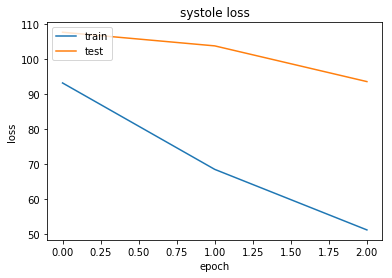

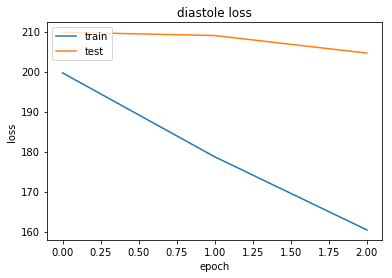

In [53]:
def train():
    """ 
    Training systole and diastole models.
    """
    model_systole = get_model()
    model_diastole = get_model()

    X_train, X_test, y_train, y_test = load_data()

    nb_iter = 3
    epochs_per_iter = 1 
    batch_size = 16
    calc_crps = 1  # calculate CRPS every n-th iteration (set to 0 if CRPS estimation is not needed)


    print('Fitting systole model...')
    hist_systole = model_systole.fit(X_train, y_train[:, 0], epochs=nb_iter,batch_size=batch_size, validation_data=(X_test, y_test[:, 0]))

    print('Fitting diastole model...')
    hist_diastole = model_diastole.fit(X_train, y_train[:, 1], epochs=nb_iter,batch_size=batch_size, validation_data=(X_test, y_test[:, 1]))


    # sigmas for predicted data, actually loss function values (RMSE)
    loss_systole = hist_systole.history['loss'][-1]
    loss_diastole = hist_diastole.history['loss'][-1]
    val_loss_systole = hist_systole.history['val_loss'][-1]
    val_loss_diastole = hist_diastole.history['val_loss'][-1]

    print('Evaluating CRPS...')
    pred_systole = model_systole.predict(X_train, batch_size=batch_size, verbose=1)
    pred_diastole = model_diastole.predict(X_train, batch_size=batch_size, verbose=1)
    val_pred_systole = model_systole.predict(X_test, batch_size=batch_size, verbose=1)
    val_pred_diastole = model_diastole.predict(X_test, batch_size=batch_size, verbose=1)

    # CDF for train and test data (actually a step function)
    cdf_train = real_to_cdf(np.concatenate((y_train[:, 0], y_train[:, 1])))
    cdf_test = real_to_cdf(np.concatenate((y_test[:, 0], y_test[:, 1])))

    # CDF for predicted data
    cdf_pred_systole = real_to_cdf(pred_systole, loss_systole)
    cdf_pred_diastole = real_to_cdf(pred_diastole, loss_diastole)
    cdf_val_pred_systole = real_to_cdf(val_pred_systole, val_loss_systole)
    cdf_val_pred_diastole = real_to_cdf(val_pred_diastole, val_loss_diastole)

    # evaluate CRPS on training data
    crps_train = crps(cdf_train, np.concatenate((cdf_pred_systole, cdf_pred_diastole)))
    print('CRPS(train) = {0}'.format(crps_train))

    # evaluate CRPS on test data
    crps_test = crps(cdf_test, np.concatenate((cdf_val_pred_systole, cdf_val_pred_diastole)))
    print('CRPS(test) = {0}'.format(crps_test))

        # save weights so they can be loaded later
    model_systole.save_weights('weights_systole_small.hdf5', overwrite=True)
    model_diastole.save_weights('weights_diastole_small.hdf5', overwrite=True)

    #print(hist_systole.history.keys())
        # summarize history for loss
    pyplot.plot(hist_systole.history['loss'])
    pyplot.plot(hist_systole.history['val_loss'])
    pyplot.title('systole loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    pyplot.show()

    #print(hist_diastole.history.keys())
        # summarize history for loss
    pyplot.plot(hist_diastole.history['loss'])
    pyplot.plot(hist_diastole.history['val_loss'])
    pyplot.title('diastole loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    pyplot.show()

train()

- Current Result from all the training examples (another machine)

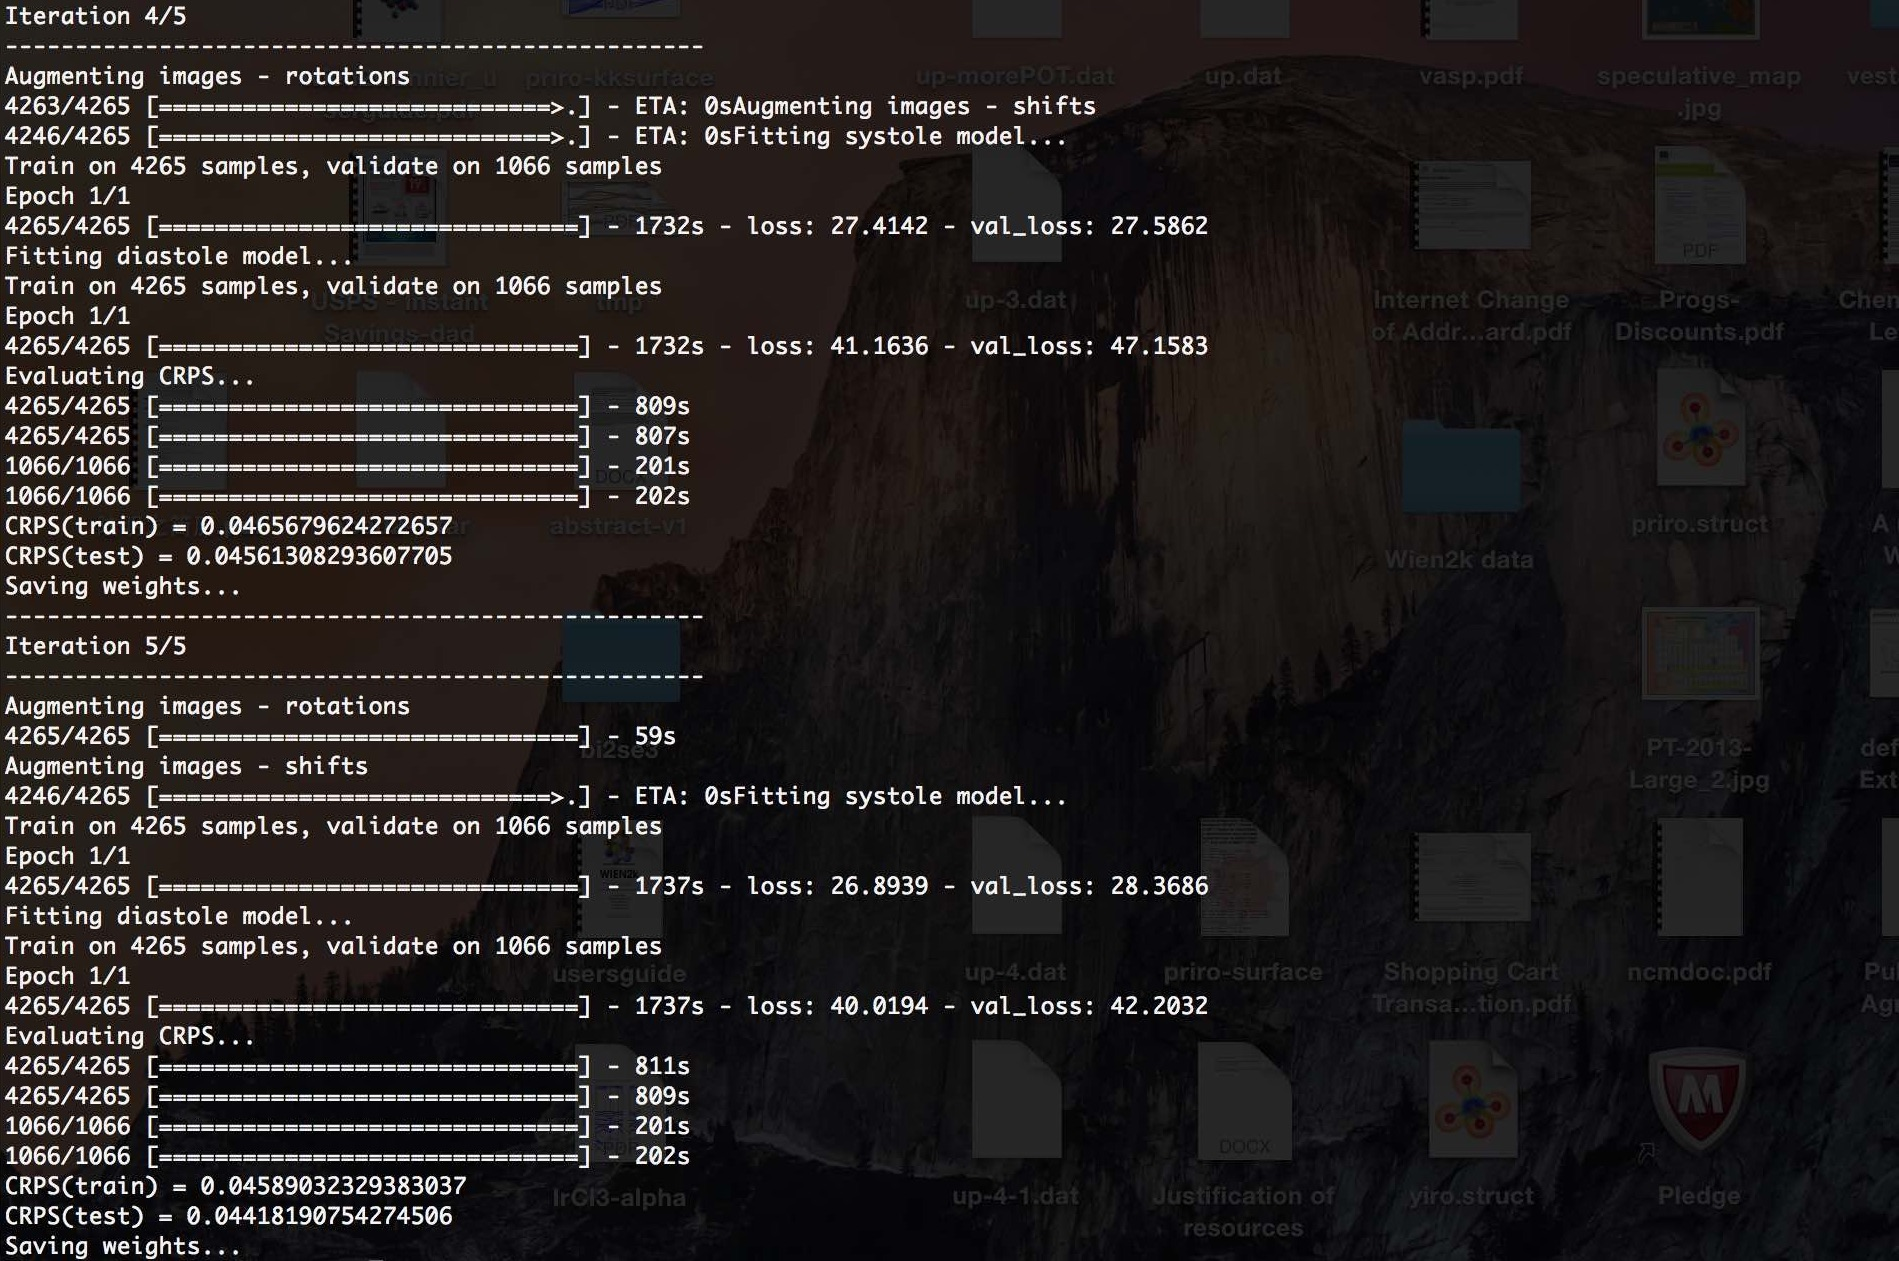

In [3]:
Image(filename='images/result.jpg') 

## The continuous ranked probability score, evaluated by CDF, in the test set has achieved 0.044!